# Модуль В. Построение, обучение и оптимизация модели

In [5]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [6]:
!pip install scikit-learn==1.3.0

     ---------------------------------------- 9.3/9.3 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.0 requires numpy>=1.22.0, but you have numpy 1.21.5 which is incompatible.


## 3.1 Кластерный анализ 

### 3.1.1 Загрузка данных

In [1]:
import pandas as pd
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data.csv')

In [97]:
df.set_index('tpep_pickup_datetime', inplace = True)
df.head()

,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count
tpep_pickup_datetime,,,,,,,,,,,,,,
2020-01-01 00:28:15,2020-01-01 00:33:03,1.2,0,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,1,1.0
2020-01-01 00:35:39,2020-01-01 00:43:04,1.2,0,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,1,1.0
2020-01-01 00:47:41,2020-01-01 00:53:52,0.6,0,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,1,1.0
2019-12-18 15:30:35,2019-12-18 15:31:35,0.0,0,1.0,2.5,0.5,0.5,0.00,0.0,0.3,6.30,2.5,12,4.0
2020-01-01 00:29:01,2020-01-01 00:40:28,0.7,0,1.0,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5,1,2.0


In [98]:
df.index = pd.to_datetime(df.index)
df.index[:5]

DatetimeIndex(['2020-01-01 00:28:15', '2020-01-01 00:35:39',
               '2020-01-01 00:47:41', '2019-12-18 15:30:35',
               '2020-01-01 00:29:01'],
              dtype='datetime64[ns]', name='tpep_pickup_datetime', freq=None)

In [255]:
resampled = df.resample('D').max()

In [256]:
resampled = resampled.dropna()

In [257]:
resampled2 = resampled

In [258]:
resampled2 = resampled2.drop(["tpep_dropoff_datetime"], axis=1)

### 3.1.2 Кластеризация KMeans

  0%|          | 0/9 [00:00<?, ?it/s]

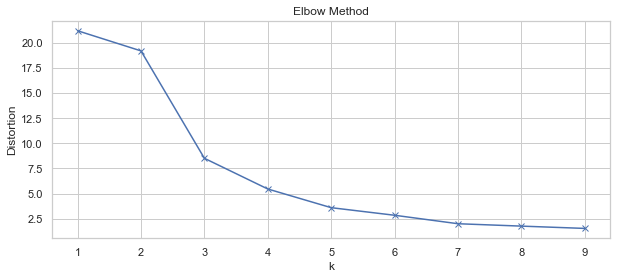

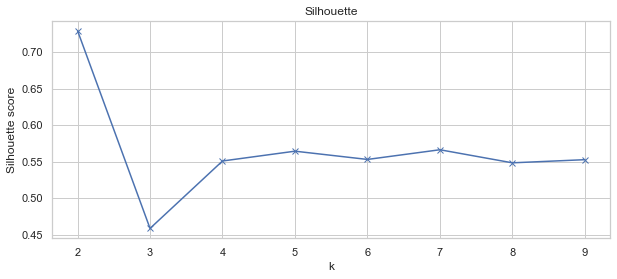

In [259]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(resampled2)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(resampled2, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

По силуэту и методу локтя можно выбрать 4 кластера.

In [260]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(resampled2)

TimeSeriesKMeans(max_iter=10, n_clusters=4, n_jobs=3)

### Визуализация центроидов кластеров KMeans

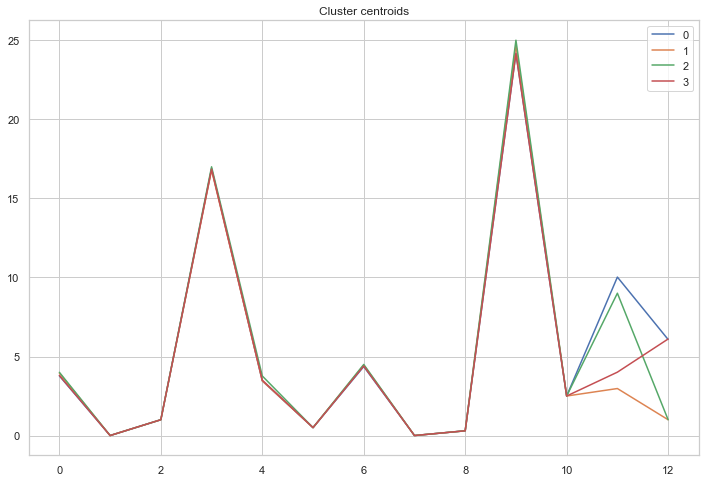

In [261]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [262]:
resampled['cluster'] = ts_kmeans.predict(resampled2)

In [263]:
resampled.head()

,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2019-12-18,2019-12-18 15:31:35,0.00,0.0,1.0,2.5,0.5,0.5,0.0,0.0,0.3,6.30,2.5,12.0,4.0,0
2019-12-31,2020-01-01 23:12:05,3.73,0.0,1.0,13.0,0.5,0.5,3.2,0.0,0.3,18.80,2.5,12.0,6.0,0
2020-01-01,2020-01-02 23:44:54,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,8.0,3
2020-01-02,2020-01-03 23:47:06,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3
2020-01-03,2020-01-04 23:53:13,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3


In [264]:
clusters = resampled['cluster'].unique()

for cluster in clusters:
    df_cluster = resampled[resampled['cluster'] == cluster]
    print(f'Таблица кластера {cluster}:')
    display(df_cluster.head(5))
    meantip = df_cluster['tip_amount'].mean()
    meantotal = df_cluster['total_amount'].mean()
    meanpas = df_cluster['passenger_count'].mean()
    meandist = df_cluster['trip_distance'].mean()
    print(f'Среднее значение суммы чаевых: {meantip}')
    print(f'Среднее значение стоимости проезда: {meantotal}')
    print(f'Среднее значение количества пассажиров: {meanpas}')
    print(f'Среднее значение дистанции поездки: {meandist}')
    print('')

Таблица кластера 0:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2019-12-18,2019-12-18 15:31:35,0.00,0.0,1.0,2.5,0.5,0.5,0.0,0.0,0.3,6.30,2.5,12.0,4.0,0
2019-12-31,2020-01-01 23:12:05,3.73,0.0,1.0,13.0,0.5,0.5,3.2,0.0,0.3,18.80,2.5,12.0,6.0,0
2020-08-01,2020-08-02 22:44:30,3.80,0.0,1.0,17.2,3.5,0.5,4.4,0.0,0.3,23.76,2.5,8.0,6.0,0
2020-08-02,2020-08-03 19:26:21,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,8.0,6.0,0
2020-08-03,2020-08-04 20:50:10,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,8.0,6.0,0


Среднее значение суммы чаевых: 4.364193548387096
Среднее значение стоимости проезда: 24.198709677419355
Среднее значение количества пассажиров: 6.077419354838709
Среднее значение дистанции поездки: 3.775032258064517

Таблица кластера 3:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2020-01-01,2020-01-02 23:44:54,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,8.0,3
2020-01-02,2020-01-03 23:47:06,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3
2020-01-03,2020-01-04 23:53:13,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3
2020-01-04,2020-01-05 23:37:48,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3
2020-01-05,2020-01-06 22:49:04,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,3


Среднее значение суммы чаевых: 4.3998122065727685
Среднее значение стоимости проезда: 24.16906103286386
Среднее значение количества пассажиров: 6.107981220657277
Среднее значение дистанции поездки: 3.7999999999999994

Таблица кластера 1:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2021-01-01,2021-01-02 18:08:32,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-02,2021-01-03 19:23:34,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-03,2021-01-04 22:00:44,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.80,2.5,1.0,1.0,1
2021-01-04,2021-01-05 22:03:28,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-05,2021-01-06 17:45:32,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1


Среднее значение суммы чаевых: 4.44590909090909
Среднее значение стоимости проезда: 24.678636363636365
Среднее значение количества пассажиров: 1.0
Среднее значение дистанции поездки: 3.9462337662337665

Таблица кластера 2:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2021-06-01,2021-06-02 23:21:17,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,6.0,1.0,2
2021-06-02,2021-06-03 23:06:00,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,25.10,2.5,6.0,1.0,2
2021-06-03,2021-06-04 23:37:47,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,25.13,2.5,6.0,1.0,2
2021-06-04,2021-06-05 21:42:53,4.0,0.0,1.0,17.1,3.5,0.5,4.5,0.0,0.3,25.13,2.5,6.0,1.0,2
2021-06-05,2021-06-06 22:35:03,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,6.0,1.0,2


Среднее значение суммы чаевых: 4.49803738317757
Среднее значение стоимости проезда: 25.013084112149535
Среднее значение количества пассажиров: 1.0
Среднее значение дистанции поездки: 4.0



- 0 кластер - поездки на такси, где наименьшая дистанция поездки, сумма чаевых и большое количество пассажиров.

- 1 кластер - поездки на такси, где большая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

- 2 кластер - поездки на такси, где наибольшая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

- 3 кластер - поездки на такси, где наименьшая стоимость поездки, средняя сумма чаевых и дистанция поездки, а также наибольшое количество пассажиров. 

### 3.1.3 Кластеризация DTW

  0%|          | 0/9 [00:00<?, ?it/s]

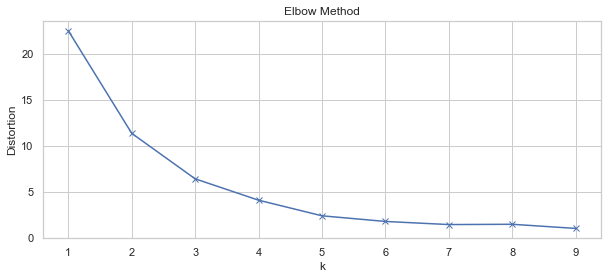

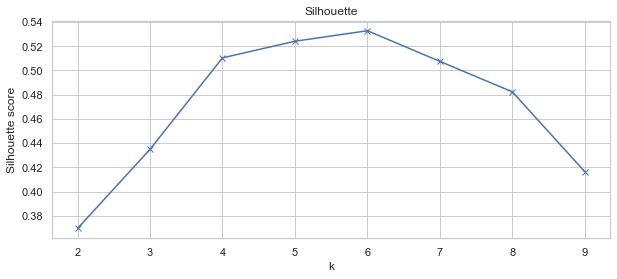

In [265]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(resampled2)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(resampled2, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

По силуэту и методу локтя можно выбрать 4 кластера.

In [266]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(resampled2)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, n_jobs=6)

### Визуализация центроидов кластеров DTW

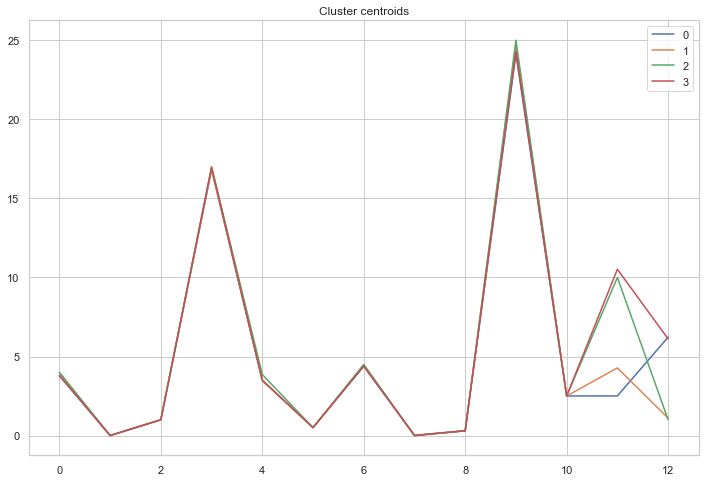

In [267]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")

plt.legend()
plt.show()

In [268]:
resampled['cluster'] = ts_kmeans_dtw.predict(resampled2)

In [269]:
resampled.head()

,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2019-12-18,2019-12-18 15:31:35,0.00,0.0,1.0,2.5,0.5,0.5,0.0,0.0,0.3,6.30,2.5,12.0,4.0,0
2019-12-31,2020-01-01 23:12:05,3.73,0.0,1.0,13.0,0.5,0.5,3.2,0.0,0.3,18.80,2.5,12.0,6.0,3
2020-01-01,2020-01-02 23:44:54,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,8.0,0
2020-01-02,2020-01-03 23:47:06,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,0
2020-01-03,2020-01-04 23:53:13,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,0


In [270]:
clusters = resampled['cluster'].unique()

for cluster in clusters:
    df_cluster = resampled[resampled['cluster'] == cluster]
    print(f'Таблица кластера {cluster}:')
    display(df_cluster.head(5))
    meantip = df_cluster['tip_amount'].mean()
    meantotal = df_cluster['total_amount'].mean()
    meanpas = df_cluster['passenger_count'].mean()
    meandist = df_cluster['trip_distance'].mean()
    print(f'Среднее значение суммы чаевых: {meantip}')
    print(f'Среднее значение стоимости проезда: {meantotal}')
    print(f'Среднее значение количества пассажиров: {meanpas}')
    print(f'Среднее значение дистанции поездки: {meandist}')
    print('')

Таблица кластера 0:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2019-12-18,2019-12-18 15:31:35,0.0,0.0,1.0,2.5,0.5,0.5,0.0,0.0,0.3,6.30,2.5,12.0,4.0,0
2020-01-01,2020-01-02 23:44:54,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,8.0,0
2020-01-02,2020-01-03 23:47:06,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,0
2020-01-03,2020-01-04 23:53:13,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,0
2020-01-04,2020-01-05 23:37:48,3.8,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,1.0,6.0,0


Среднее значение суммы чаевых: 4.3819183673469375
Среднее значение стоимости проезда: 24.117020408163274
Среднее значение количества пассажиров: 6.085714285714285
Среднее значение дистанции поездки: 3.7844897959183665

Таблица кластера 3:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2019-12-31,2020-01-01 23:12:05,3.73,0.0,1.0,13.0,0.5,0.5,3.2,0.0,0.3,18.80,2.5,12.0,6.0,3
2020-09-01,2020-09-02 19:57:19,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,9.0,6.0,3
2020-09-02,2020-09-03 20:01:56,3.80,0.0,1.0,17.2,3.5,0.5,4.4,0.0,0.3,24.36,2.5,9.0,6.0,3
2020-09-03,2020-09-04 22:53:45,3.80,0.0,1.0,17.0,3.5,0.5,4.4,0.0,0.3,24.36,2.5,9.0,6.0,3
2020-09-04,2020-09-05 21:35:59,3.80,0.0,1.0,17.2,3.5,0.5,4.4,0.0,0.3,24.36,2.5,9.0,6.0,3


Среднее значение суммы чаевых: 4.390569105691056
Среднее значение стоимости проезда: 24.310081300813017
Среднее значение количества пассажиров: 6.1138211382113825
Среднее значение дистанции поездки: 3.7994308943089425

Таблица кластера 1:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2021-01-01,2021-01-02 18:08:32,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-02,2021-01-03 19:23:34,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-03,2021-01-04 22:00:44,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.80,2.5,1.0,1.0,1
2021-01-04,2021-01-05 22:03:28,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1
2021-01-05,2021-01-06 17:45:32,4.0,0.0,1.0,17.0,3.5,0.5,4.5,0.0,0.3,24.96,2.5,1.0,1.0,1


Среднее значение суммы чаевых: 4.460976744186047
Среднее значение стоимости проезда: 24.771581395348836
Среднее значение количества пассажиров: 1.0
Среднее значение дистанции поездки: 3.961488372093023

Таблица кластера 2:


,tpep_dropoff_datetime,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,passenger_count,cluster
tpep_pickup_datetime,,,,,,,,,,,,,,,
2021-08-01,2021-08-02 22:24:31,4.0,0.0,1.0,17.0,3.50,0.5,4.5,0.0,0.3,24.96,2.5,8.0,1.0,2
2021-08-02,2021-08-03 23:40:19,4.0,0.0,1.0,17.0,3.50,0.5,4.5,0.0,0.3,24.96,2.5,8.0,1.0,2
2021-08-03,2021-08-04 22:22:19,4.0,0.0,1.0,17.0,3.50,0.5,4.5,0.0,0.3,24.96,2.5,8.0,1.0,2
2021-08-04,2021-08-05 21:49:26,4.0,0.0,1.0,17.0,4.75,0.5,4.5,0.0,0.3,24.96,2.5,8.0,1.0,2
2021-08-05,2021-08-06 23:23:18,4.0,0.0,1.0,17.0,3.50,0.5,4.5,0.0,0.3,25.13,2.5,8.0,1.0,2


Среднее значение суммы чаевых: 4.497647058823529
Среднее значение стоимости проезда: 25.015816993464057
Среднее значение количества пассажиров: 1.0
Среднее значение дистанции поездки: 4.0



- 0 кластер - поездки на такси, где наименьшая дистанция поездки, сумма чаевых и большое количество пассажиров.

- 1 кластер - поездки на такси, где большая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

- 2 кластер - поездки на такси, где наибольшая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

- 3 кластер - поездки на такси, где наименьшая стоимость поездки, средняя сумма чаевых и дистанция поездки, а также наибольшое количество пассажиров. 

## 3.2 Разбиение выборки на обучающую и тестовую

In [40]:
import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product  

In [24]:
def tsplot(y, lags=None, figsize=(20, 12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [113]:
sample_data = df.sample(n=1000)

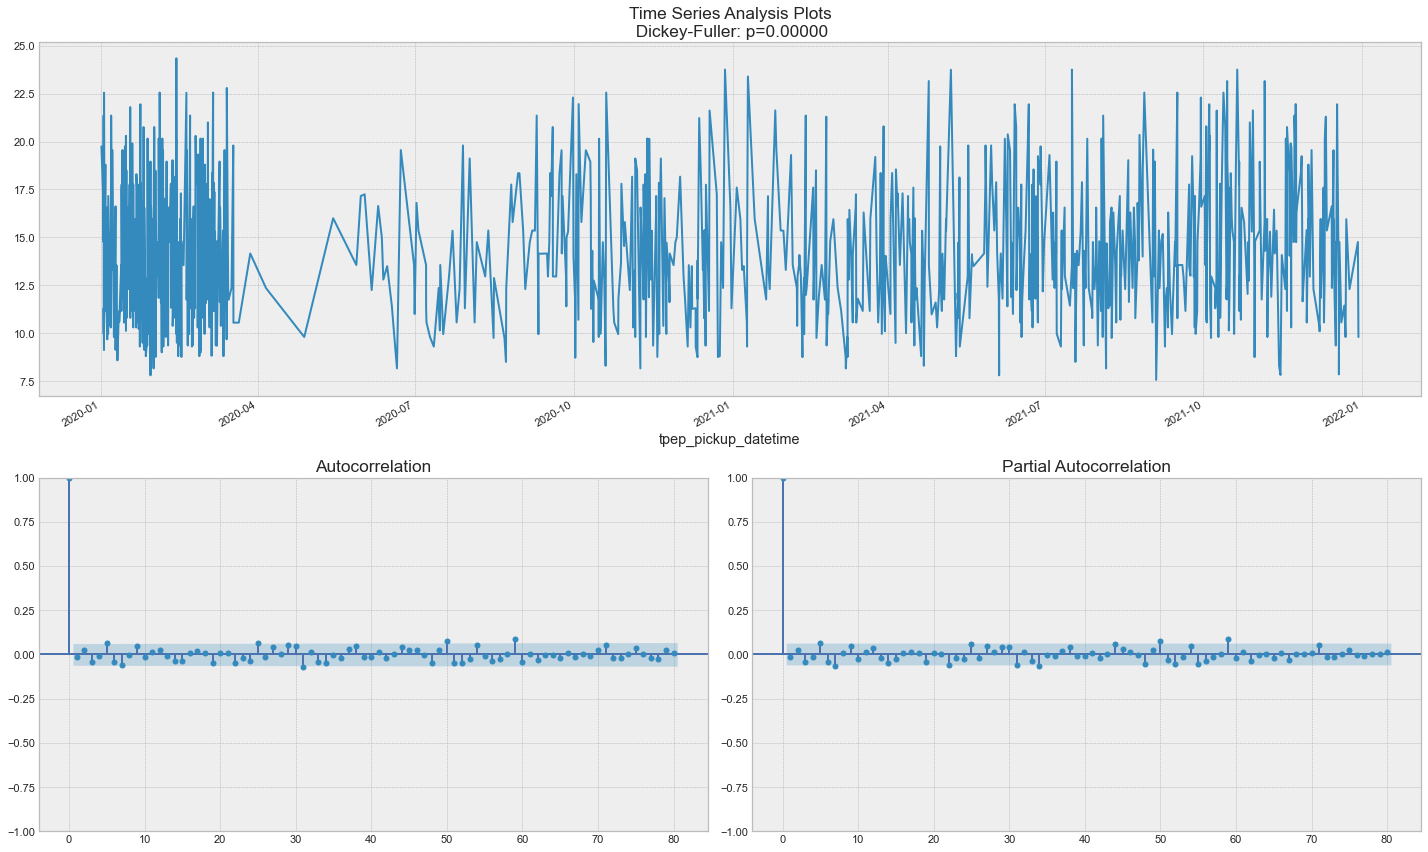

In [114]:
amount0 = sample_data.total_amount
tsplot(amount0,80)

На графике автокорреляции и частичной автокорреляции можно увидеть, что наблюдается большой пик в районе 58 лага.

Для попыки приведения временного ряда к виду белого шума происходит вычитание из исходного ряда тот же ряд сдвинутые на 58, так как 58 лаг отвечает максимуму автокорреляции.

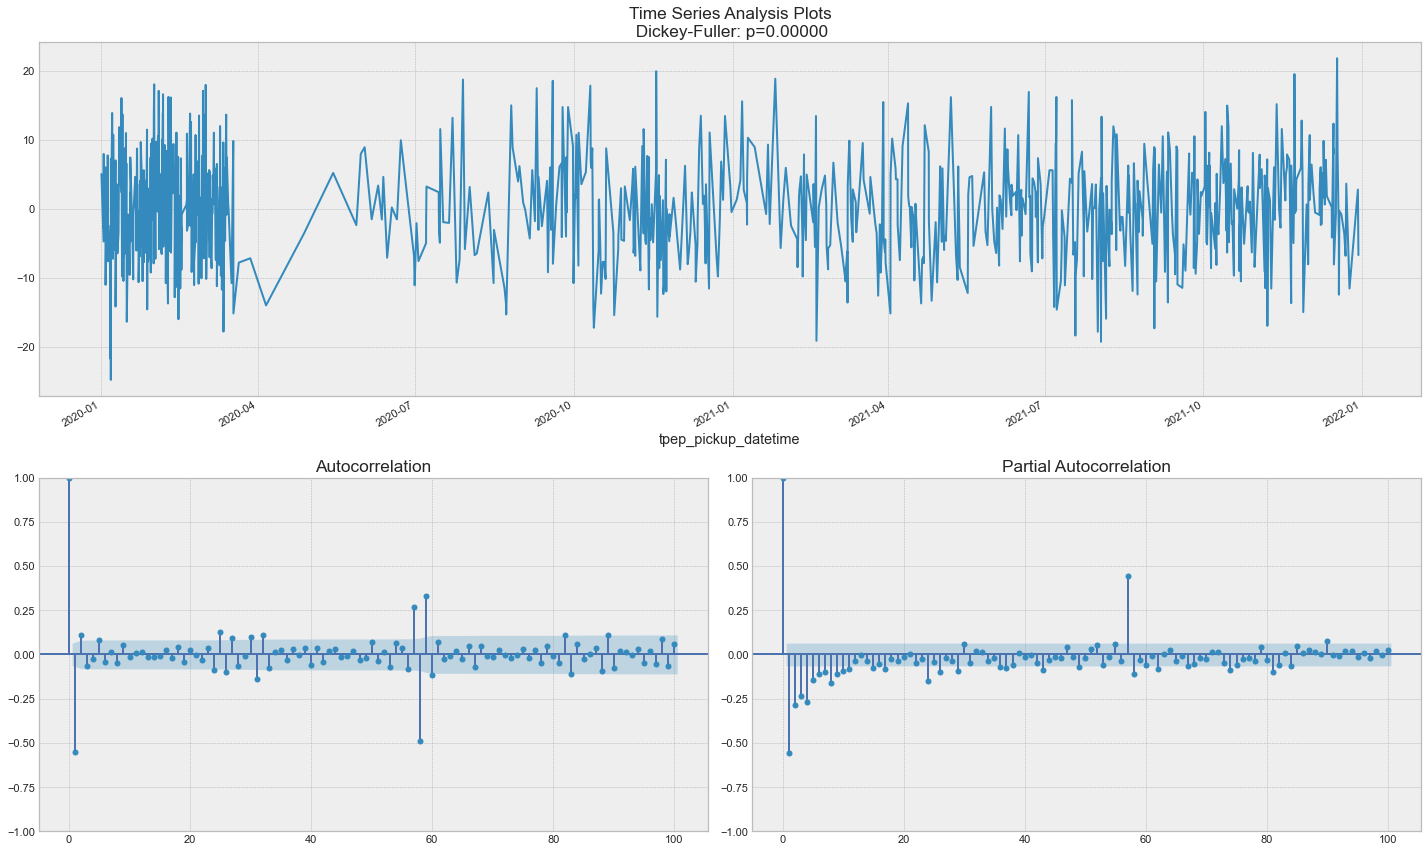

In [115]:
amount1 = amount0 - amount0.shift(58)
amount2 = amount1 - amount1.shift(1)
amount3 = amount2 - amount2.shift(1)
amount4 = amount3 - amount3.shift(1)
amount5 = amount4 - amount4.shift(1)

tsplot(amount2[59:],100)

In [ ]:
#p = 11
#q = 1
#d = 1
#s = 58
#P = 1
#Q = 1
#D = 1

Варьирование значение параметров для нахождения лучших параметров для модели.

In [116]:
ps = range(7, 11)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 58

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [118]:
def optimizeSARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        try:
            model=sm.tsa.statespace.SARIMAX(sample_data.total_amount, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [41]:
from itertools import product   
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
sns.set()

### Оптимизация SARIMA

In [120]:

result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/48 [00:00<?, ?it/s]

In [121]:
result_table.head(7)

,parameters,aic
0,"(7, 1, 0, 1)",5258.142323
1,"(9, 1, 0, 1)",5259.584384
2,"(7, 1, 1, 1)",5260.112140
3,"(8, 1, 0, 1)",5260.135721
4,"(10, 1, 0, 1)",5261.414342
5,"(9, 1, 1, 1)",5261.561825
6,"(8, 2, 0, 1)",5261.676487


Получена таблица результатов с параметрами отсортированных по качеству модели.

Получение лучшей модели SARIMA.

In [122]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(sample_data.total_amount, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       total_amount   No. Observations:                 1000
Model:             SARIMAX(7, 1, 1)x(0, 1, 1, 58)   Log Likelihood               -2619.071
Date:                            Wed, 19 Jul 2023   AIC                           5258.142
Time:                                    17:43:39   BIC                           5306.612
Sample:                                         0   HQIC                          5276.618
                                           - 1000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0293      0.034     -0.868      0.385      -0.095       0.037
ar.L2          0.0274      0.033   

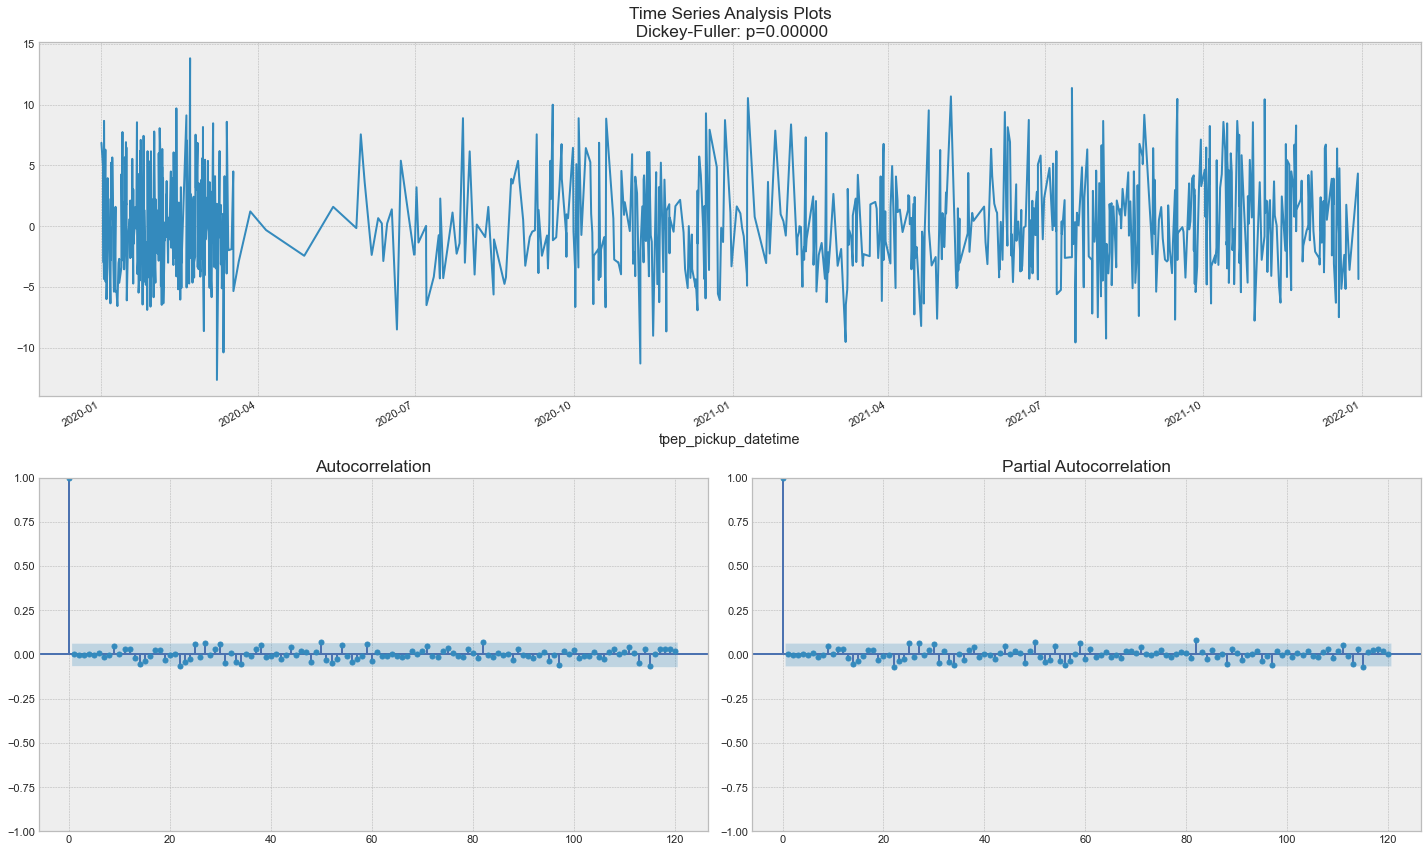

In [123]:
tsplot(best_model.resid[58+1:], lags=120)

<AxesSubplot:xlabel='tpep_pickup_datetime'>

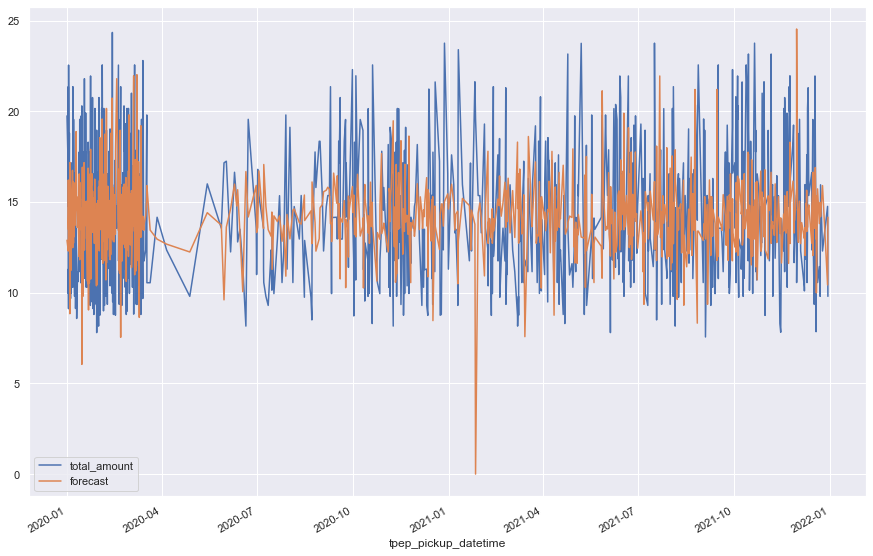

In [185]:
sample_data['forecast']=best_model.predict()
sample_data[['total_amount','forecast']].plot(figsize=(15,10))

Был взят ряд total_amount с различными лагами.

In [202]:
data = pd.DataFrame(sample_data.total_amount.copy())
data = data.reset_index(drop=True)
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_49,lag_50,lag_51,lag_52,lag_53
993,17.76,9.13,14.34,9.00,13.56,19.56,9.96,22.56,18.50,15.99,18.55,9.80,11.76,12.36,12.35,21.96
994,12.96,17.76,9.13,14.34,9.00,13.56,19.56,9.96,22.56,18.50,15.99,14.00,9.80,11.76,12.36,12.35
995,15.30,12.96,17.76,9.13,14.34,9.00,13.56,19.56,9.96,22.56,18.50,14.30,14.00,9.80,11.76,12.36
996,11.16,15.30,12.96,17.76,9.13,14.34,9.00,13.56,19.56,9.96,22.56,12.30,14.30,14.00,9.80,11.76
997,19.55,11.16,15.30,12.96,17.76,9.13,14.34,9.00,13.56,19.56,9.96,12.36,12.30,14.30,14.00,9.80
998,15.87,19.55,11.16,15.30,12.96,17.76,9.13,14.34,9.00,13.56,19.56,11.16,12.36,12.30,14.30,14.00
999,11.88,15.87,19.55,11.16,15.30,12.96,17.76,9.13,14.34,9.00,13.56,9.80,11.16,12.36,12.30,14.30


Были взяты другие ряды, которые могут оказать влияние значение total_amount. были взяты ряды trip_distance, tip_amount, month и passenger_count, так как они имеют множество отличающихся друг от друга значений в отличии от других рядов.

In [203]:
mask = ['trip_distance','tip_amount','month','passenger_count']
temps = sample_data[mask]
temps = temps.reset_index(drop=True)

Добавление новых лагов.

In [204]:
data['trip_distance'] = temps.trip_distance
data['tip_amount'] = temps.tip_amount
data['month'] = temps.month
data['passenger_count'] = temps.passenger_count
vals = list(range(1,5))+list(range(-5,0))
for i in vals:
    data["trip_distance_lag_{}".format(i)] = data.trip_distance.shift(i)
    data["tip_amount_lag_{}".format(i)] = data.tip_amount.shift(i)
    data["month_lag_{}".format(i)] = data.month.shift(i)
    data["passenger_count_lag_{}".format(i)] = data.passenger_count.shift(i)

data.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,month_lag_-3,passenger_count_lag_-3,trip_distance_lag_-2,tip_amount_lag_-2,month_lag_-2,passenger_count_lag_-2,trip_distance_lag_-1,tip_amount_lag_-1,month_lag_-1,passenger_count_lag_-1
0,19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,1.07,2.00,10.0,1.0,2.42,2.76,2.0,1.0
1,16.56,19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,2.00,2.00,5.0,1.0,1.07,2.00,10.0,1.0
2,10.80,16.56,19.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.0,1.90,2.05,2.0,1.0,2.00,2.00,5.0,1.0
3,17.80,10.80,16.56,19.58,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.78,2.00,10.0,1.0,1.90,2.05,2.0,1.0
4,12.35,17.80,10.80,16.56,19.58,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.90,2.75,1.0,1.0,1.78,2.00,10.0,1.0


При работе с временными рядами необходимо сохранять последователность точек. Именно для этого применяется кросс-валидация.

In [205]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [206]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Разделение данных на у - целевую переменную и множество независимых переменных Х.

In [207]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## 3.3 Построение модели прогнозирования временного ряда

### 3.3.1 Линейная регрессия

In [208]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,normas = True):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    if normas:
        coefs = coefs.loc[coefs.ne(0).all(axis=1)]
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

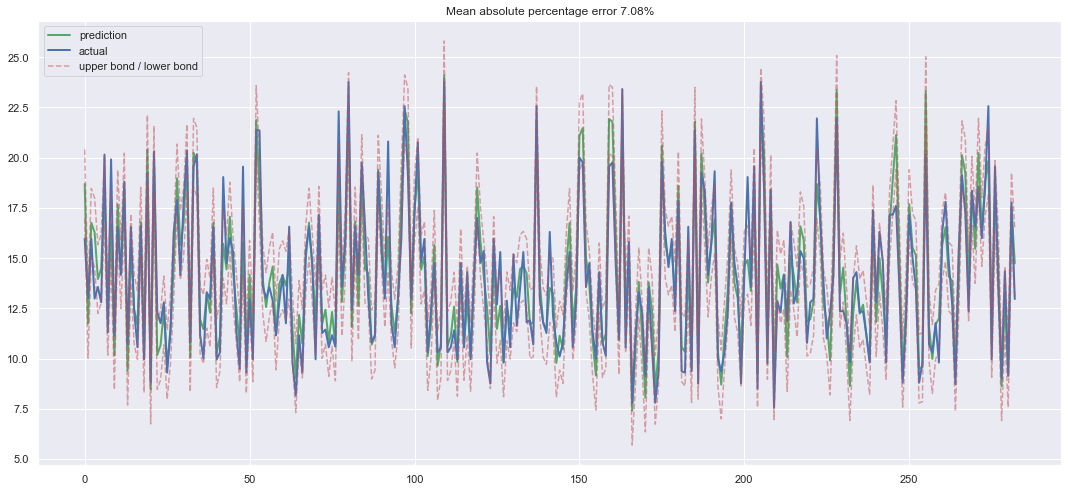

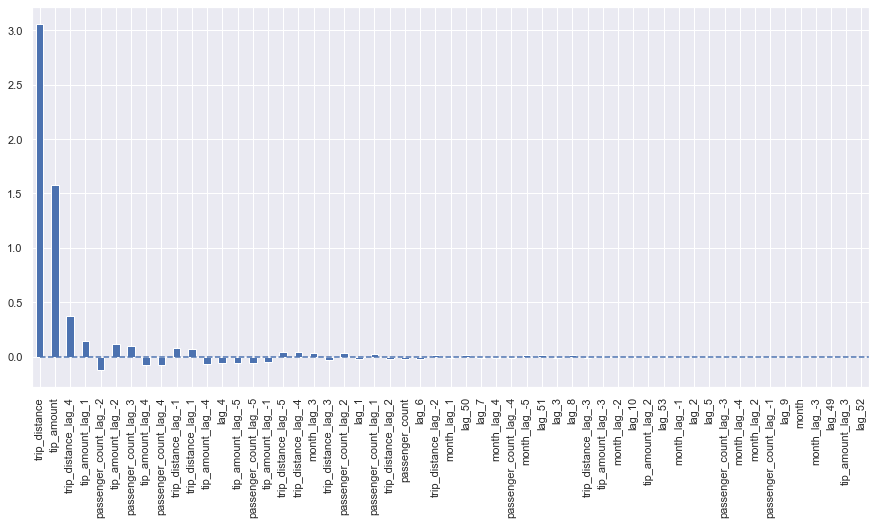

In [210]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Линейная регрессия показала процент ошибки 7.08%.

### 3.3.2 KNeighborsRegressor

In [212]:
from sklearn.neighbors import KNeighborsRegressor

In [213]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)

KNeighborsRegressor()

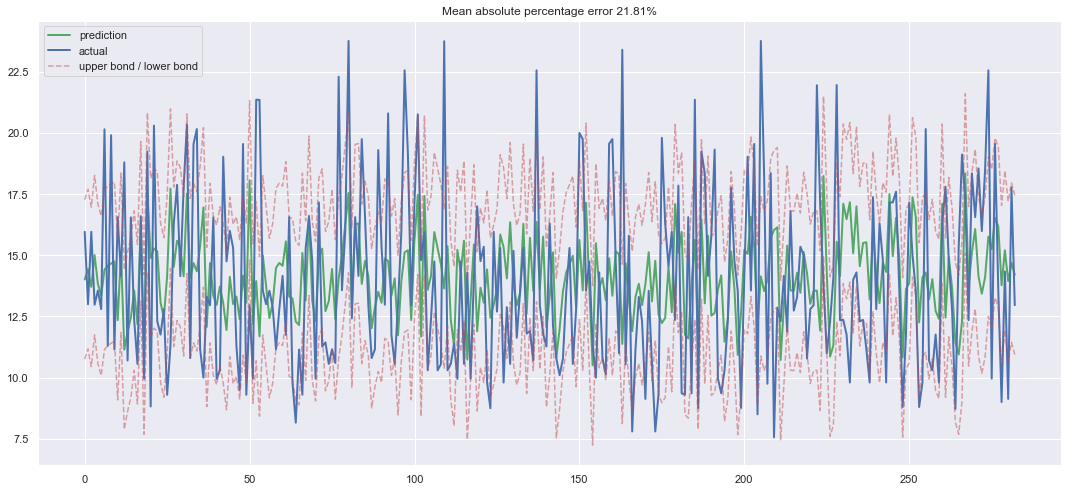

In [215]:
plotModelResults(kn, plot_intervals=True)

Модель KNeighborsRegressor показала процент ошибки 21.81%.

### 3.3.3 RandomForestRegressor

In [216]:
from sklearn.ensemble import RandomForestRegressor

In [217]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

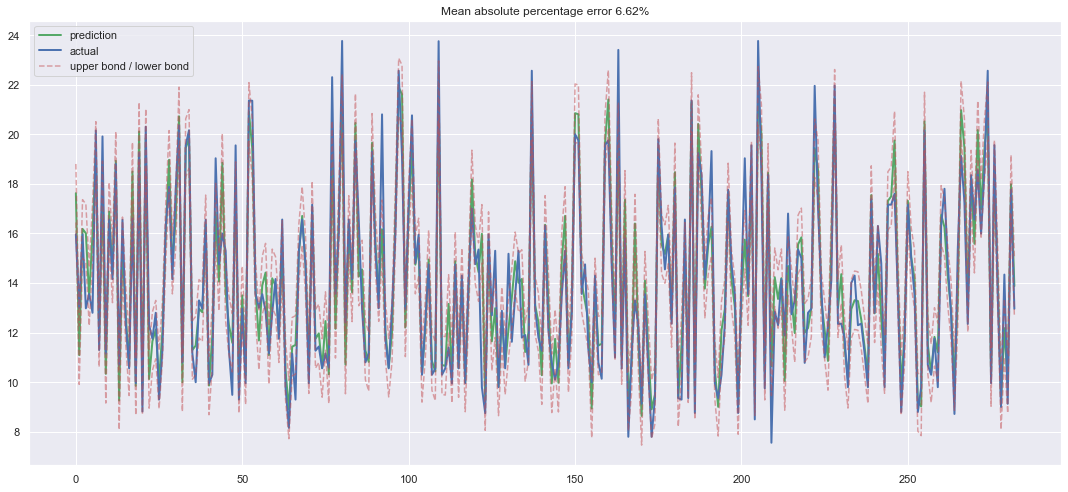

In [224]:
plotModelResults(rf, plot_intervals=True)


Модель RandomForestRegressor показала наименьший процент ошибок 6.62%.

Для дальнейшего использования берется модель RandomForestRegressor.

### Сохранение модели

In [219]:
import joblib

In [220]:
joblib.dump(rf, "model.pkl") #Сохранение модели

['model.pkl']

В итоге была получена модель для прогноза цен на такси.

## 3.4 Отчет

### 3.4.1 Отчет о кластерном анализе

1. Загрузка датафрейма

2. Кластеризация KMeans

По силуэту и методу локтя кластеризации KMeans можно выбрать 4 кластера.

Визуализация центроидов кластеров KMeans.

3. Кластеризация DTW

По силуэту и методу локтя кластеризации DTW можно выбрать 4 кластера.

Визуализация центроидов кластеров DTW.

0 кластер - поездки на такси, где наименьшая дистанция поездки, сумма чаевых и большое количество пассажиров.

1 кластер - поездки на такси, где большая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

2 кластер - поездки на такси, где наибольшая дистанция поездки, стоимость проезда, сумма чаевых,а также малое количество пассажиров.

3 кластер - поездки на такси, где наименьшая стоимость поездки, средняя сумма чаевых и дистанция поездки, а также наибольшое количество пассажиров.

### 3.4.2 Отчет об разбиении выборки на обучающую и тестовую  

1. На графике автокорреляции и частичной автокорреляции можно увидеть, что наблюдается большой пик в районе 58 лага. 

2. Для попыки приведения временного ряда к виду белого шума происходит вычитание из исходного ряда тот же ряд сдвинутые на 58, так как 58 лаг отвечает максимуму автокорреляции.

3. Варьирование значение параметров для нахождения лучших параметров для модели.

4. Оптимизация SARIMA

5. Получена таблица результатов с параметрами отсортированных по качеству модели.

6. Получение лучшей модели SARIMA.

7. Был взят ряд total_amount с различными лагами.

8. Были взяты другие ряды, которые могут оказать влияние значение total_amount. были взяты ряды trip_distance, tip_amount, month и passenger_count, так как они имеют множество отличающихся друг от друга значений в отличии от других рядов.

9. Добавление новых лагов.

10. При работе с временными рядами необходимо сохранять последователность точек. Именно для этого применяется кросс-валидация.

11. Разделение данных на у - целевую переменную и множество независимых переменных Х.

### 3.4.3 Отчет о построении модели прогнозирования временного ряда

1. Линейная регрессия

Написан метод для вывод результата модели.

Линейная регрессия показала процент ошибки 7.08%.

2. KNeighborsRegressor

Модель KNeighborsRegressor показала процент ошибки 21.81%.

3. RandomForestRegressor

Модель RandomForestRegressor показала наименьший процент ошибок 6.62%.

Для дальнейшего использования берется модель RandomForestRegressor.

4. Сохранение модели

В итоге была получена модель для прогноза цен на такси.

In [2]:
import joblib

In [4]:
model = joblib.load('model.pkl')

In [61]:
test = pd.DataFrame()

In [ ]:
['trip_distance','tip_amount','month','passenger_count']

In [62]:
test['trip_distance'] = [1,1.4, 2, 2.9, 1000]
test['tip_amount'] = [2,2.4, 1.5, 3, 3]
test['month'] = [1,4,3,12, 7]
test['passenger_count'] = [2,3, 1, 1, 1]

In [15]:
X_test_new = test[['trip_distance', 'tip_amount', 'month', 'passenger_count']]

In [16]:
X_test_new

,trip_distance,tip_amount,month,passenger_count
0,1.0,2.0,1,2
1,1.4,2.4,4,3
2,2.0,1.5,3,1
3,2.9,3.0,12,1


In [22]:
vals = list(range(1,3))+list(range(-3,0))
for i in vals:
    X_test_new["trip_distance_lag_{}".format(i)] = X_test_new.trip_distance.shift(i)
    X_test_new["tip_amount_lag_{}".format(i)] = X_test_new.tip_amount.shift(i)
    X_test_new["month_lag_{}".format(i)] = X_test_new.month.shift(i)
    X_test_new["passenger_count_lag_{}".format(i)] = X_test_new.passenger_count.shift(i)

X_test_new.head()

,trip_distance,tip_amount,month,passenger_count,trip_distance_lag_1,tip_amount_lag_1,month_lag_1,passenger_count_lag_1,trip_distance_lag_2,tip_amount_lag_2,...,month_lag_-3,passenger_count_lag_-3,trip_distance_lag_-2,tip_amount_lag_-2,month_lag_-2,passenger_count_lag_-2,trip_distance_lag_-1,tip_amount_lag_-1,month_lag_-1,passenger_count_lag_-1
0,1.0,2.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,1.0,2.0,1.5,3.0,1.0,1.4,2.4,4.0,3.0
1,1.4,2.4,4,3,1.0,2.0,1.0,2.0,NaN,NaN,...,NaN,NaN,2.9,3.0,12.0,1.0,2.0,1.5,3.0,1.0
2,2.0,1.5,3,1,1.4,2.4,4.0,3.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.9,3.0,12.0,1.0
3,2.9,3.0,12,1,2.0,1.5,3.0,1.0,1.4,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
model.predict(X_test_new)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [2]:
df = pd.read_csv('data.csv')

In [3]:
data = df.sample(n=1000)

In [3]:
data2 = pd.DataFrame(data.total_amount.copy())
data2.columns = ["y"]

In [4]:
data2['trip_distance'] = data.trip_distance
data2['tip_amount'] = df.tip_amount
data2['month'] = df.month
data2['passenger_count'] = df.passenger_count

In [5]:
data2.head()

,y,trip_distance,tip_amount,month,passenger_count
0,11.27,1.2,1.47,1,1.0
1,12.30,1.2,1.50,1,1.0
2,10.80,0.6,1.00,1,1.0
3,6.30,0.0,0.00,12,4.0
4,14.15,0.7,2.35,1,2.0


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [7]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [8]:
y = data2.dropna().y
X = data2.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [43]:
import numpy as np

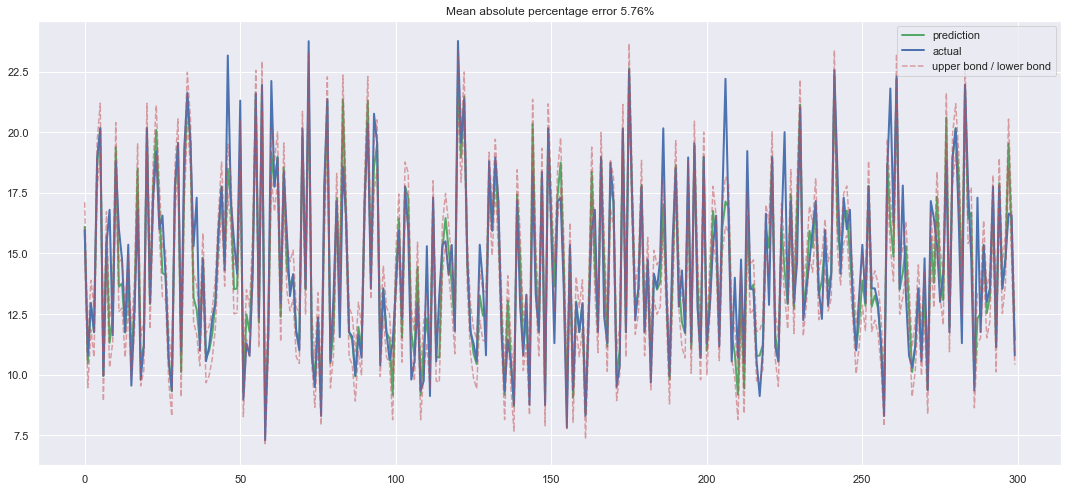

In [44]:
plotModelResults(rf, plot_intervals=True)

In [45]:
joblib.dump(rf, "model2.pkl") #Сохранение модели

['model2.pkl']

In [46]:
model = joblib.load('model2.pkl')

In [63]:
test

,trip_distance,tip_amount,month,passenger_count
0,1.0,2.0,1,2
1,1.4,2.4,4,3
2,2.0,1.5,3,1
3,2.9,3.0,12,1
4,1000.0,3.0,7,1


In [64]:
test['total_amount_predict'] = model.predict(test)

In [65]:
test

,trip_distance,tip_amount,month,passenger_count,total_amount_predict
0,1.0,2.0,1,2,11.6971
1,1.4,2.4,4,3,14.0886
2,2.0,1.5,3,1,14.3574
3,2.9,3.0,12,1,20.4004
4,1000.0,3.0,7,1,19.6702


In [57]:
test

,trip_distance,tip_amount,month,passenger_count,total_amount_predict
0,1.0,2.0,1,2,11.6971
1,1.4,2.4,4,3,14.0886
2,2.0,1.5,3,1,14.3574
3,2.9,3.0,12,1,20.4004
4,24.3,20.0,7,1,21.1962
